### World Wide Products Inc
#### Intro:
#### This project focuses on processing and analyzing existing data to make a forecasting models to determine the demand for a particular product. 
#### In my personal opinion, this is a relatively simple data, and its complexity cannot support a perfect prediciton.
#### This project consists of three steps
##### - Importing data and Droping null value
##### - Exploratory Data Analysis and Feature selection
##### - Use Time series forecasting models to predict data

 ### First setp: Importing data and Droping null value 

In [380]:
df = pd.read_csv('../input/Historical Product Demand.csv', parse_dates=['Date'])

In [381]:
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [382]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [383]:

df = df.dropna()
df.isna().any()

Product_Code        False
Warehouse           False
Product_Category    False
Date                False
Order_Demand        False
dtype: bool

 ### Second Step: Exploratory Data Analysis and Feature selection

#### Let us analyze the data in the list to select a representative product to predict demand

In [384]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,1000
freq,16936,764447,470266,2075,112263
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN


#### Acording to the describe , we can found that there are 2160 type of products, 4 warehouse, 33 type of category. 

In [385]:
amount_product = df.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
amount_product.head(5)

,Product_Code,counts
1348,Product_1359,16936
1284,Product_1295,10575
1367,Product_1378,9770
619,Product_0620,9428
1275,Product_1286,8888


#### Form this talbe we can find the higest amount_product is Product_1359
#### Lets check the other characteristic for this product.

In [386]:
df_product_1359 = df.loc[df['Product_Code'] == 'Product_1359']
df_product_1359.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
276,Product_1359,Whse_J,Category_019,2012-04-18,80000
282,Product_1359,Whse_J,Category_019,2012-05-21,70000
289,Product_1359,Whse_J,Category_019,2012-06-26,80000
292,Product_1359,Whse_J,Category_019,2012-07-17,100000
296,Product_1359,Whse_J,Category_019,2012-08-24,100000


In [387]:
df_product_1359.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,16936,16936,16936,16936,16936
unique,1,1,1,1232,161
top,Product_1359,Whse_J,Category_019,2013-01-07 00:00:00,1000
freq,16936,16936,16936,35,2578
first,NaN,NaN,NaN,2012-01-05 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-06 00:00:00,NaN


#### According this table, we konw that procut_1359 only has 1 type of warehouse and 1 product_category. so we can delete warehouse and Product_category, and product_code.These columns will not have any effect on our model training or prediction

In [388]:
del df_product_1359['Warehouse']
del df_product_1359['Product_Category']
del df_product_1359['Product_Code']

In [389]:
df_product_1359.head(10)

,Date,Order_Demand
276,2012-04-18,80000
282,2012-05-21,70000
289,2012-06-26,80000
292,2012-07-17,100000
296,2012-08-24,100000
301,2012-10-04,80000
306,2012-10-29,80000
939,2012-01-12,84000
940,2012-01-20,1000
941,2012-02-03,1000


In [390]:
df_product_1359.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          16936 non-null  datetime64[ns]
 1   Order_Demand  16936 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 396.9+ KB


#### Lets transfer the Date to Data-time form which accpet by  Forcasting model.
#### Same processing on Order_Demand

In [391]:
df_product_1359['Date']=pd.to_datetime(df_product_1359['Date'])
df_product_1359["Order_Demand"] = pd.to_numeric(df_product_1359["Order_Demand"], errors='coerce')
df_product_1359.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          16936 non-null  datetime64[ns]
 1   Order_Demand  16912 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 396.9 KB


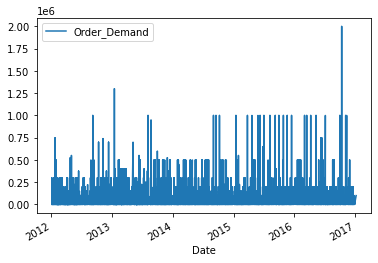

In [392]:

df_product_1359.set_index('Date', inplace=True)
df_product_1359.plot(kind='line')


####  This picture does not seem to tell us the obvious trend of the data. Let's try to use Time Series Forcasting to predict future demand of Product_1359

## Third Step:Time Series Forcasting
* #### I will use Prophet from Facbook to do the Time Series Forecasting

In [393]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
#https://facebook.github.io/prophet/docs/quick_start.html

#### Creating model and fit our dataset.

In [394]:

df_product_1359 = pd.DataFrame({'ds': df_product_1359.index, 'y': df_product_1359.Order_Demand})
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=False)
model.fit(df_product_1359)

### lets predict trend for next 12 month by using Prophet model

In [395]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
1232,2017-02-01,36859.494993,-48493.026828,122665.192264
1233,2017-03-01,31551.896194,-59518.113352,122788.816690
1234,2017-04-01,29674.742516,-57584.169062,122438.659457
1235,2017-05-01,31059.936732,-58859.330219,111772.574428
1236,2017-06-01,26017.859506,-63230.413683,112920.242597
1237,2017-07-01,30895.463208,-52826.218091,119288.653384
1238,2017-08-01,36267.653272,-52344.472635,119166.113012
1239,2017-09-01,32639.435581,-55864.555814,121128.820715
1240,2017-10-01,33962.883214,-62756.977531,119848.574542
1241,2017-11-01,35678.424827,-51897.519660,125303.005445


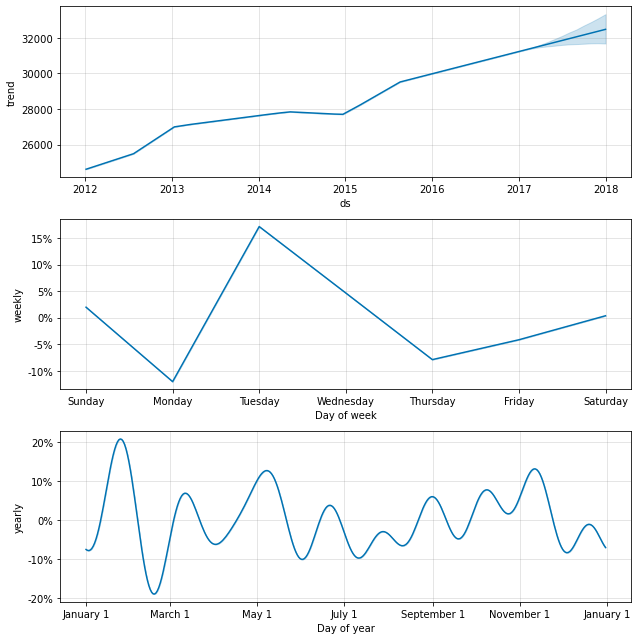

In [396]:
fig2 = model.plot_components(forecast)


### Conclusion

#### By using Time Series Forecasting withou the testing data. I can’t confirm the accuracy of this model without testing data. Judging from the annual demand growth chart, product-1359 seems to show a relatively linear growth. I personally do not believe in this model very much. Unsupervised learning based solely on time and demand can only be used as a reference. The value of data is not high. The trained model may be very different from the actual data

#### However the Facebook model is really very clean and straightforward. I think if the dataset itself can provide more parameters such as holidays and consumption patterns . I think prophet should be able to provide better training results.